In [72]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import wave
import librosa.display
import sklearn
import json
import sys, os
warnings.filterwarnings('ignore')
from IPython.display import Audio
from os.path import exists

In [73]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
# locate corrent directory

In [74]:
train_dataset_location = '../data/train/'
train_wav_location = os.path.join(train_dataset_location, 'wav/')
train_changed_wav_location = os.path.join(train_dataset_location, 'converted_wavs/')
train_txt_location = os.path.join(train_dataset_location, 'trsTrain.txt')
test_dataset_location = 'test/' 
lexicon_location = 'train/'

In [75]:
train_file_names = os.listdir(train_wav_location)
train_wav_paths = [ os.path.join(train_wav_location, file_name)
                    for file_name in train_file_names]
print(f"There are {len(train_wav_paths)} Amharic wav files in the training set")

There are 10875 Amharic wav files in the training set


In [76]:
def tran_loader(filename):
    name_to_text = {}
    with open(filename, encoding="utf-8")as f:
        f.readline()
        for line in f:
            name = line.split("</s>")[1]
            name = name.replace('(', '')
            name = name.replace(')', '')
            name = name.replace('\n', '')
            name = name.replace(' ', '')
            text = line.split("</s>")[0]
            text = text.replace("<s>", "")
            name_to_text[name] = text
        return name_to_text

In [77]:
transcription = tran_loader(train_txt_location)

In [78]:
transcription

{'tr_2_tr01002': ' የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል ',
 'tr_3_tr01003': ' በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል ',
 'tr_4_tr01004': ' ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው ',
 'tr_5_tr01005': ' ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች ',
 'tr_6_tr01006': ' ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት ',
 'tr_7_tr01007': ' እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው ',
 'tr_8_tr01008': ' እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ ',
 'tr_9_tr01009': ' አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው ',
 'tr_10_tr01010': ' ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር ',
 'tr_11_tr01011': ' ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል ',
 'tr_12_tr01012': ' ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም ',
 'tr_13_tr01013': ' ኢትዮጵያ ም ሰራዊቷ በ ኤርትራ እንደሚ 

In [79]:
import wave, array
def change_channel_to_stereo(file1, output):
    try:
        ifile = wave.open(file1)
        print(ifile.getparams())
        # (1, 2, 44100, 2013900, 'NONE', 'not compressed')
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
        assert comptype == 'NONE'  # Compressed not supported yet
        array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
        left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
        ifile.close()

        stereo = 2 * left_channel
        stereo[0::2] = stereo[1::2] = left_channel

        ofile = wave.open(output, 'w')
        ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
        print(ofile.getnchannels())
        ofile.writeframes(stereo.tobytes())
        ofile.close()
        return ofile.getnchannels()
    except Exception as e:
        print(e)

In [80]:
def resize_audio(audio: np.array, size: int) -> np.array:
        
        resized = librosa.util.fix_length(audio, size, axis=1)
        print(f"Audio resized to {size} samples")
        return resized

In [81]:
# we will use the first wav file to visualize its characteristics
#librosa load returns by default time-series as numpy array and with the default sample rate of 22KHZ so we just changed it to 44kHZ
samples, sample_rate = librosa.load(train_wav_location+'tr_1_tr01001.wav' , sr=44100)
print(samples)
print(sample_rate)

[-0.00502738 -0.00588078 -0.00577551 ... -0.00516981 -0.00347923
  0.        ]
44100


In [ ]:
for waves in range(len(train_wav_paths)):

In [109]:
# Top five mono files converted to stereo
for file_name in train_file_names[0:len(train_wav_paths)]:
    change_channel_to_stereo(os.path.join(train_wav_location, file_name) , 
                             os.path.join(train_changed_wav_location, file_name))
     

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=34816, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=227328, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=237568, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=196608, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=165888, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=204800, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=40960, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=178176, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=165888, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=190464, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=206848, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=190464, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000,

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=161792, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=208896, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=217088, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=215040, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=167936, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=149504, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=184320, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=223232, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=167936, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=229376, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=229376, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=251904, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=190464, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=198656, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=149504, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=192512, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=194560, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=268288, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=219136, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=180224, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=219136, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=229376, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=184320, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000,

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=176128, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=188416, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=165888, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=264192, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=186368, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=184320, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=192512, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=260096, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=167936, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=204800, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=212992, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=251904, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=190464, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=221184, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=178176, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=192512, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=178176, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=223232, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=212992, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=155648, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=176128, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=178176, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=155648, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=196608, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=161792, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=188416, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=155648, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=229376, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=208896, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=225280, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=204800, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=239616, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=192512, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=264192, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=194560, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=38912, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=217088, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=194560, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=38912, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=159744, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=167936, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=229376, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=231424, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=147456, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=180224, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=139264, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=239616, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=221184, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=251904, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=188416, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=38912, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=149504, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=149504, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=165888, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=145408, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=167936, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=198656, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=243712, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=215040, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=223232, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=194560, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=34816, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=155648, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=161792, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=30720, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=135168, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=151552, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=190464, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=45056, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=79872, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=194560, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=36864, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=212992, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=67584, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=153600, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=198656, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfram

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=102400, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=96256, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=196608, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=231424, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nf

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=110592, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=118784, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=247808, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=184320, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=172032, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=75776, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=186368, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=108544, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=49152, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=133120, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=51200, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=149504, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=57344, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=157696, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=59392, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=131072, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=92160, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=180224, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=161792, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, 

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=126976, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=55296, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=120832, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=178176, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=163840, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=202752, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=47104, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=40960, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=112640, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=182272, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=141312, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=169984, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=122880, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=100352, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=114688, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, n

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=143360, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=116736, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65536, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=129024, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=61440, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=174080, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=63488, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=124928, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=53248, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=43008, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=83968, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=69632, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=73728, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes

2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=180224, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=81920, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=137216, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=94208, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nfra

KeyboardInterrupt: 

In [83]:
ipd.Audio(samples, rate=sample_rate)

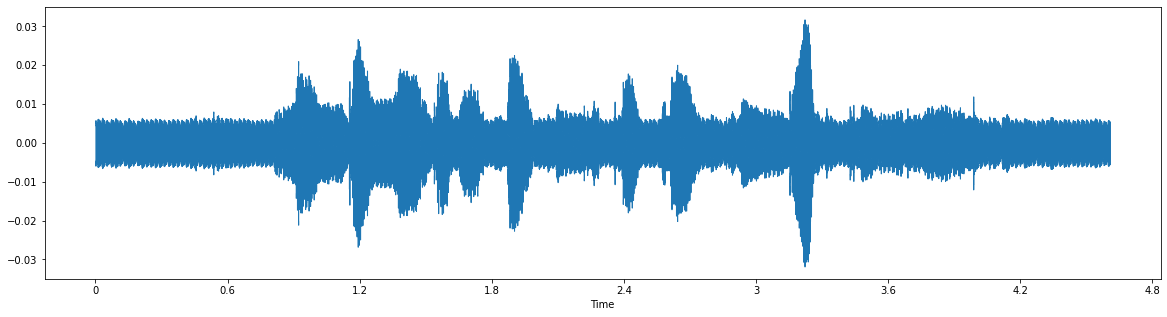

In [84]:
# Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.show()

### Convert time domain into frequency domain
- `Fourier Transform is a mathematical operation that changes the domain (x-axis) of a signal from time to frequency`
- `The Fourier Transform can, in fact, speed up the training process of convolutional neural networks`

- `the Fast Fourier Transform (FFT) is an algorithm that determines Discrete Fourier Transform of an input significantly faster than computing it directly. In computer science lingo, the FFT reduces the number of computations needed for a problem of size N from O(N^2) to O(NlogN)`

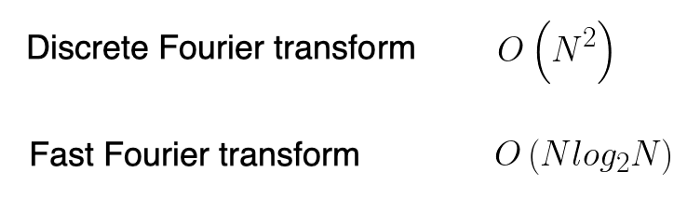

In [85]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    - FFT
    
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

spe_samples, frequency = spectrogram(samples)
print(frequency)
print(spe_samples)

[0.        0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375   0.1015625
 0.109375  0.1171875 0.125     0.1328125 0.140625  0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1875    0.1953125 0.203125  0.2109375
 0.21875   0.2265625 0.234375  0.2421875 0.25      0.2578125 0.265625
 0.2734375 0.28125   0.2890625 0.296875  0.3046875 0.3125    0.3203125
 0.328125  0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875  0.4296875
 0.4375    0.4453125 0.453125  0.4609375 0.46875   0.4765625 0.484375
 0.4921875 0.5       0.5078125 0.515625  0.5234375 0.53125   0.5390625
 0.546875  0.5546875 0.5625    0.5703125 0.578125  0.5859375 0.59375
 0.6015625 0.609375  0.6171875 0.625     0.6328125 0.640625  0.6484375
 0.65625   0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75      0.7578125
 0.765625  0.77343

In [86]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    # plt.savefig('spectogramfeature.png')

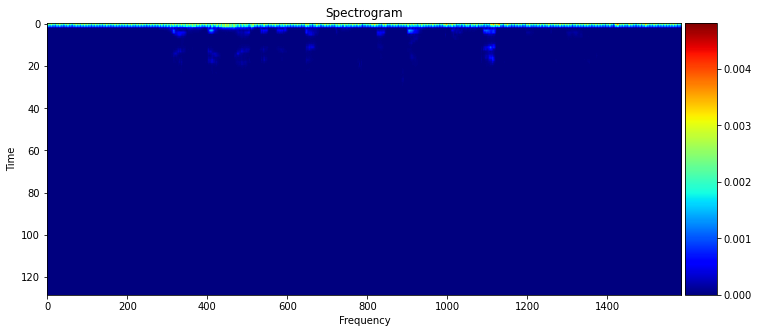

In [68]:
plot_spectrogram_feature(spe_samples)

#### The Short-time Fourier transform (STFT)
- is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time.
- Resolution is its key Importance

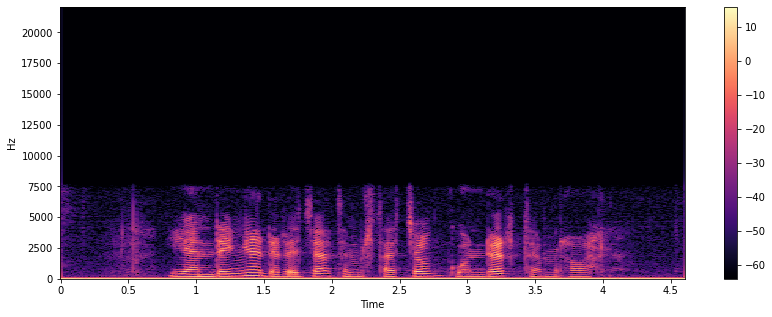

In [87]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()
# plt.savefig('specshow.png')

### Visualization of features of audio Spectral 

**`spectral Centroid (Center frequencies)`**

In [88]:
spectral_centroids = librosa.feature.spectral_centroid(
    samples, sr=sample_rate)[0]

spectral_centroids.shape

(397,)

In [90]:
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

<Figure size 864x288 with 0 Axes>

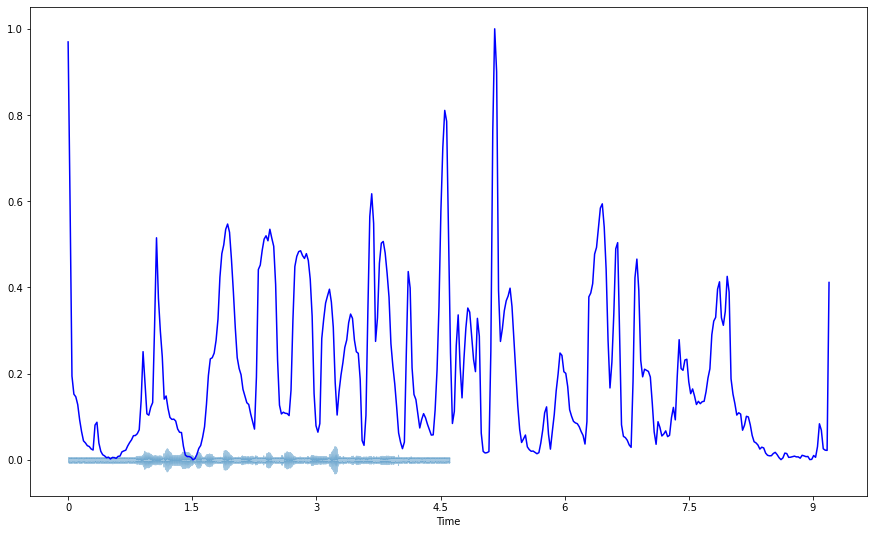

In [91]:
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(15, 9))
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
plt.show()

**`Spectral rolloff`**

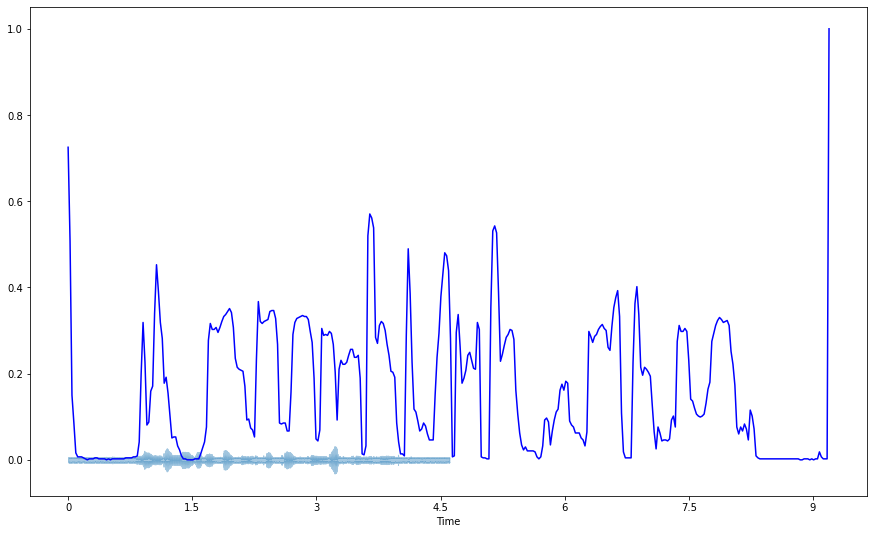

In [92]:
spectral_rolloff = librosa.feature.spectral_rolloff(
    samples+0.01, sr=sample_rate)[0]
# print(spectral_rolloff)
plt.figure(figsize=(15, 9))
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='b')
plt.show()

**`Spectral Bandwidth`**

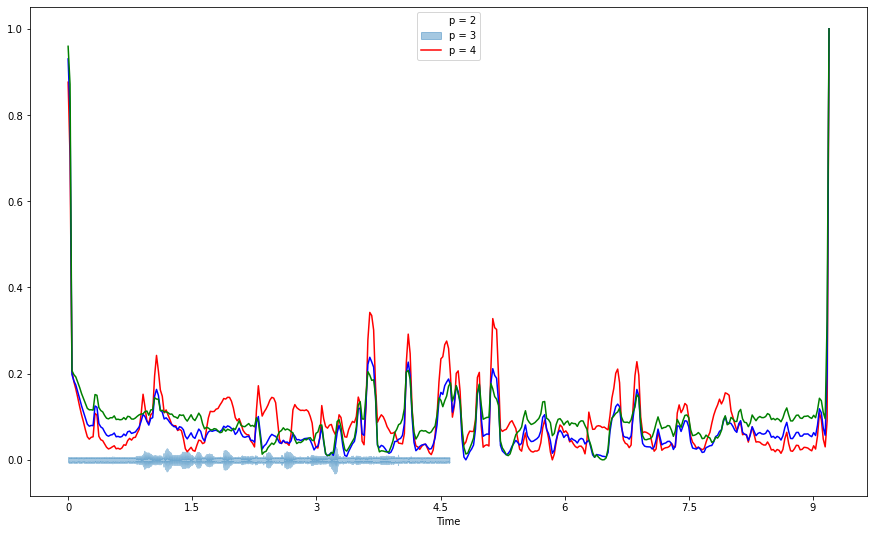

In [94]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(
    samples+0.01, sr=sample_rate, p=4)[0]
plt.figure(figsize=(15, 9))

librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='b')
plt.plot(t, normalize(spectral_bandwidth_4), color='g')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.show()

### Data Augmentation by Time shifting

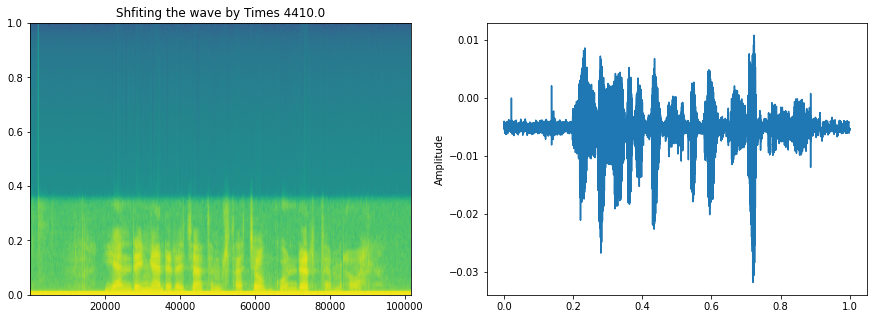

In [95]:
def plot_spec(data: np.array, sr: int) -> None:
    '''
    Function for plotting spectrogram along with amplitude wave graph
    '''

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
    ax[0].specgram(data, Fs=2)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0, 1, len(data)), data)
    # fig.savefig('spectogramamplitude.png')
wav_roll = np.roll(samples, int(sample_rate/10))
plot_spec(data=wav_roll, sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)

In [97]:
class AugmentAudio:
    def __init__(self) -> None:
        pass

    def add_noise(self, data: np.array, noise_factor: float) -> np.array:
        noise = np.random.randn(len(data))
        augmented_data = data + noise_factor * noise
        augmented_data = augmented_data.astype(type(data[0]))

        return augmented_data

    def add_time_shift(self,
                       data: np.array,
                       sampling_rate: int,
                       shift_max: float,
                       shift_direction: str) -> np.array:
        shift = np.random.randint(sampling_rate * shift_max)
        if shift_direction == 'right':
            shift = -shift
        elif shift_direction == 'both':
            direction = np.random.randint(0, 2)
            if direction == 1:
                shift = -shift
        augmented_data = np.roll(data, shift)
        if shift > 0:
            augmented_data[:shift] = 0
        else:
            augmented_data[shift:] = 0

        return augmented_data
    
    def change_pitch(self, data, sampling_rate, pitch_factor):
        return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

    def change_speed(self, data, speed_factor):
        return librosa.effects.time_stretch(data, speed_factor)
audio_augmenter = AugmentAudio()

**`Adding noise`**

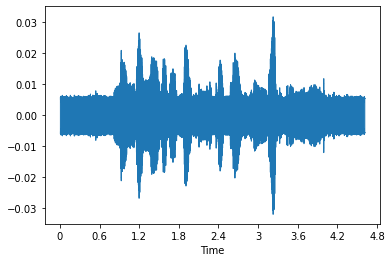

In [100]:
noise_added = audio_augmenter.add_noise(samples, noise_factor=0.0001)
librosa.display.waveshow(noise_added, sr=sample_rate)
ipd.Audio(data=noise_added, rate=sample_rate)

**`time shifting with the rate sample_rate/5`**

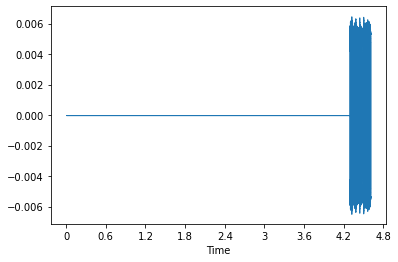

In [101]:
time_shifted = audio_augmenter.add_time_shift(samples, sample_rate, 5, 'both')
librosa.display.waveshow(time_shifted, sr=sample_rate)
ipd.Audio(data=time_shifted, rate=sample_rate)

**`applying using pitch shift`**

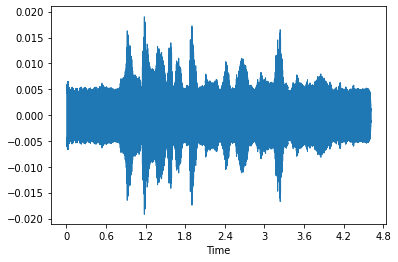

In [102]:
pitch_shifted = audio_augmenter.change_pitch(samples, sample_rate, pitch_factor=0.1)
librosa.display.waveshow(pitch_shifted, sr=sample_rate)
ipd.Audio(data=pitch_shifted, rate=sample_rate)

### Feature Extraction 

### `Mel-Frequency Cepstral Coefficients`

(20, 397)


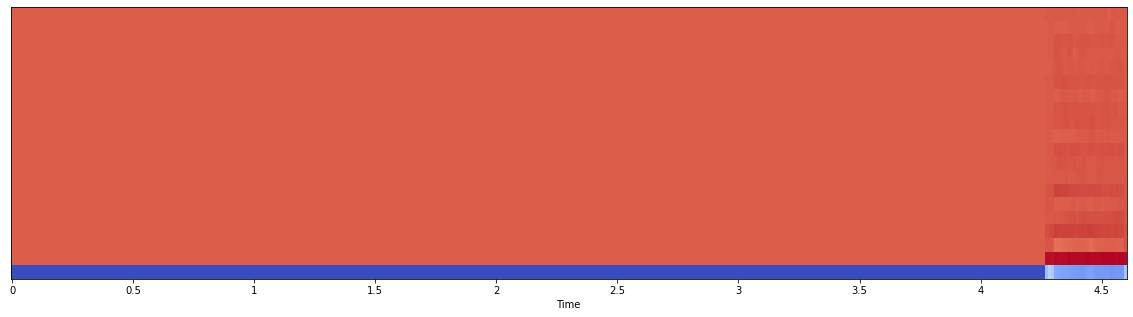

In [103]:
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(time_shifted, sr=sample_rate)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
print(mfccs.shape)

In [117]:
#path = train_changed_wav_location
def meta_data(trans, path):
    target = []
    features = []
    mode=[]
    rmse=[]
    spec_cent=[]
    spec_bw=[]
    rolloff=[]
    zcr=[]
    mfcc=[]
    rate=[]
    filenames = []
    duration_of_recordings = []
    for index, k in enumerate(trans):
        if index < 5:
            filename = path + k + ".wav"
            next_file_name = path + k + "changed.wav"
            if exists(filename):
                # stereo = make_stereo(filename, next_file_name)
                filenames.append(filename)
                audio, fs = librosa.load(filename, sr=44100)
                chroma_stft = librosa.feature.chroma_stft(y = audio, sr = fs)
                rmse.append(np.mean(librosa.feature.rms(y = audio)))
                spec_cent.append(np.mean(librosa.feature.spectral_centroid(y = audio, sr = fs)))
                spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y = audio, sr = fs)))
                rolloff.append(np.mean(librosa.feature.spectral_rolloff(y = audio, sr = fs)))
                zcr.append(np.mean(librosa.feature.zero_crossing_rate(audio)))
                mfcc.append(np.mean(librosa.feature.mfcc(y = audio, sr = fs)))
                duration_of_recordings.append(float(len(audio)/fs))
                rate.append(fs)
                mode.append('mono') # if stereo == 1 else 'stereo')
                lable = trans[k]
                target.append(lable)
    return filenames, target, duration_of_recordings,mode,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc,rate

In [118]:
## save extracted data to a data frame
filenames, target, duration_of_recordings,mode ,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc,rate = meta_data(transcription, train_wav_location)
data_am = pd.DataFrame({'key': filenames, 'text': target,
                    'duration': duration_of_recordings, 'mode': mode , 'rate': rate ,'rmse': rmse,'spec_cent' :spec_cent,'spec_bw': spec_bw,"rolloff" :rolloff,"zcr": zcr,"mfcc": mfcc})
data_am

key  \
0  ../data/train/wav/tr_2_tr01002.wav   
1  ../data/train/wav/tr_3_tr01003.wav   
2  ../data/train/wav/tr_4_tr01004.wav   
3  ../data/train/wav/tr_5_tr01005.wav   
4  ../data/train/wav/tr_6_tr01006.wav   

                                                text   duration  mode   rate  \
0   የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...  16.384014  mono  44100   
1   በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...  14.592018  mono  44100   
2                         ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው    4.736009  mono  44100   
3   ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...   8.192018  mono  44100   
4   ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያ...   8.704014  mono  44100   

       rmse   spec_cent      spec_bw      rolloff       zcr       mfcc  
0  0.005557  769.171143  1256.989803  1618.360516  0.003095 -17.840212  
1  0.005417  783.725021  1286.675508  1654.442077  0.001926 -18.258934  
2  0.005535  687.372255  1161.387180  1368.097283  0.004953 -18.796532  
3  0.005626  782.274709  1257.456211  1691.149453  0.003393 -18.172558  
4  0.005613  675.773427  1236.190170  1418.406445  0.003391 -18.153847

In [120]:
#export data to csv and save as dataS.csv 
import csv
with open('../data_test/trainiing_am.csv', 'w', encoding="utf-8") as f:
    for key in transcription.keys():
        f.write("%s,%s\n"%(key,transcription[key]))

**`save the processed data`**

In [108]:
# tutorial info <data.to_json('train_corpus.json',orient='records')>
md_json = data.to_dict(orient='records')
with open("training_data.json", 'w') as f:
  json.dump(md_json, f, indent=2)